# Rapport technique - Campagne marketing

In [50]:
#bilbiothèques nécessaires
import pandas as pd
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay


## **Analyse exploratoire**
#### Chargement et exploration des données:

In [3]:
df_camp= pd.read_csv("C:/Users/HP/Desktop/DATABOOTCAMP/Rush4/Camp_Market.csv", sep=";")
print(df_camp.head())

     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  2012-09-04       58       635  ...                  7             0   
1  2014-03-08       38        11  ...                  5             0   
2  2013-08-21       26       426  ...                  4             0   
3  2014-02-10       26        11  ...                  6             0   
4  2014-01-19       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0

On va supprimer les deux colonnes **Z_CostContact** et **Z_Revenue**, car elles contiennent une valeur identique pour chaque clients et sont peu informatives

In [4]:
df_camp.drop(columns=['Z_CostContact', 'Z_Revenue'], inplace=True)
print(df_camp.head())

     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumCatalogPurchases  NumStorePurchases  \
0  2012-09-04       58       635  ...                   10                  4   
1  2014-03-08       38        11  ...                    1                  2   
2  2013-08-21       26       426  ...                    2                 10   
3  2014-02-10       26        11  ...                    0                  4   
4  2014-01-19       94       173  ...                    3                  6   

   NumWebVisitsMonth  AcceptedCmp3  Accepted

In [5]:
print("Taille du fichier .csv : ")
print(df_camp.shape)

Taille du fichier .csv : 
(2240, 27)


- Vérifier si on a des doublons en partant de la colonne ID:

In [6]:
df_camp['ID'].nunique()

2240

2240 idenfitiants, pour 2240 clients, cela ne garantit rien, on va donc eliminer la colonne ID et chercher dans le reste des colonnes si des doublons existent, puis on les supprime.

In [7]:
df_no_ID = df_camp.drop(columns=["ID"])
doublons = df_camp[df_no_ID.duplicated(keep=False)]
pd.set_option('display.max_rows', None)
print(doublons)

         ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
15     2114        1946         PhD         Single  82800.0        0   
17     4939        1946  Graduation       Together  37760.0        0   
23     4047        1954         PhD        Married  65324.0        0   
24     1409        1951  Graduation       Together  40689.0        0   
29     1966        1965         PhD        Married  84618.0        0   
30     6864        1989      Master       Divorced  10979.0        0   
31     3033        1963      Master       Together  38620.0        0   
38     8595        1973  Graduation          Widow  42429.0        0   
39     2968        1943         PhD       Divorced  48948.0        0   
42     8430        1957  Graduation       Together  21994.0        0   
54     9381        1978  Graduation        Married  66373.0        1   
60     6853        1982      Master         Single  75777.0        0   
80     3332        1985  Graduation         Single  29760.0     

On a en réalité 358 doublons une fois la colonne ID supprimée.

- Suppression des doublons:

In [8]:
df = df_camp.drop_duplicates(subset=[col for col in df_camp.columns if col != "ID"], keep="first").copy()

print(df.shape)

(2058, 27)


On a donc en realité les données de 2058 clients.

En plus de la suppression des doublons, on va supprimé deux colonnes qui sont inutiles dans notre analyse, les colonnes **Z_CostContract** et **Z_revenue**, car elles ont des valeurs identiques pour chaque clients.

- Voir les valeurs manquantes : 

In [9]:
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Response                0
dtype: int64

On a donc 24 valeurs manquantes dans la colonne 'income' (salaire) qu'on devra traiter.

On va imputer ces valeurs avec la moyenne de cette colonne (income).

In [10]:
df['Income'] = df['Income'].fillna(df['Income'].mean())
print(df['Income'].mean())
print(df['Income'].isna().sum())

52357.79154375614
0


- Visualisation des données :

In [11]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
count,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,...,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000
mean,5600.764334,1968.787172,52357.791544,0.445578,0.509232,48.951895,303.921769,26.234694,167.704568,37.329446,...,2.660836,5.770651,5.319728,0.073372,0.076774,0.071914,0.065598,0.012634,0.009718,0.152089
std,3256.894682,11.973898,25377.602472,0.537556,0.546489,28.999189,336.528217,39.750728,228.303238,54.657215,...,2.933824,3.239113,2.439907,0.260810,0.266297,0.258409,0.247638,0.111714,0.098124,0.359195
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2811.750000,1959.000000,35701.750000,0.000000,0.000000,24.000000,23.000000,1.000000,16.000000,3.000000,...,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5515.500000,1970.000000,52054.000000,0.000000,0.000000,49.000000,174.000000,8.000000,67.000000,12.000000,...,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8442.750000,1977.000000,68242.500000,1.000000,1.000000,74.000000,504.000000,33.000000,229.500000,50.000000,...,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- Observation sur les statistiques descriptives :

Le jeu de données comporte **2240 clients** avec un âge moyen d’environ **56 ans** et un revenu annuel moyen de **52 000**, mais avec de fortes disparités. **La majorité n’a pas d’enfants à domicile.** Les dépenses et la récence des achats varient beaucoup selon les individus. 

Les taux de réponse aux campagnes marketing sont faibles (environ 15 % pour la dernière). Z_CostContact et Z_Revenue sont constantes et donc peu informatives.

- Visualiser les résultats de toutes les campagnes :

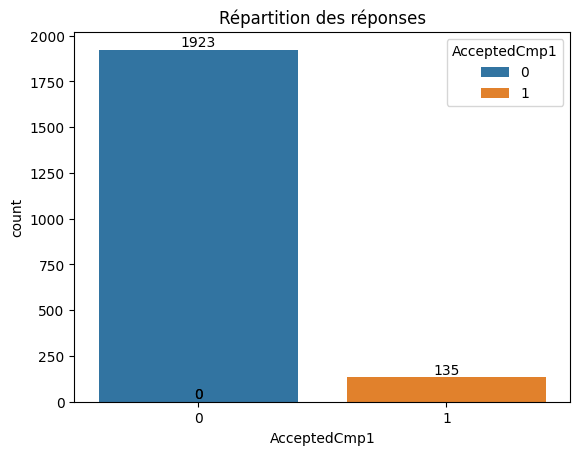

In [12]:
sns.countplot(x='AcceptedCmp1', hue ='AcceptedCmp1', data=df)
plt.title("Répartition des réponses")

for p in plt.gca().patches:
    plt.gca().annotate(
        f'{int(p.get_height())}',           
        (p.get_x() + p.get_width() / 2,     
         p.get_height()),                   
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.show()

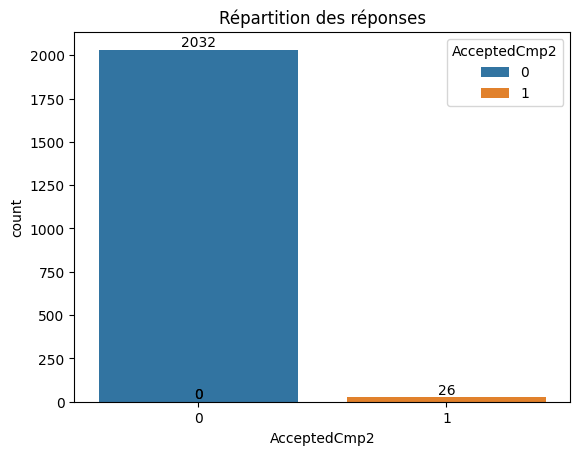

In [13]:
sns.countplot(x='AcceptedCmp2', hue ='AcceptedCmp2', data=df)
plt.title("Répartition des réponses")

for p in plt.gca().patches:
    plt.gca().annotate(
        f'{int(p.get_height())}',           
        (p.get_x() + p.get_width() / 2,     
         p.get_height()),                   
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.show()

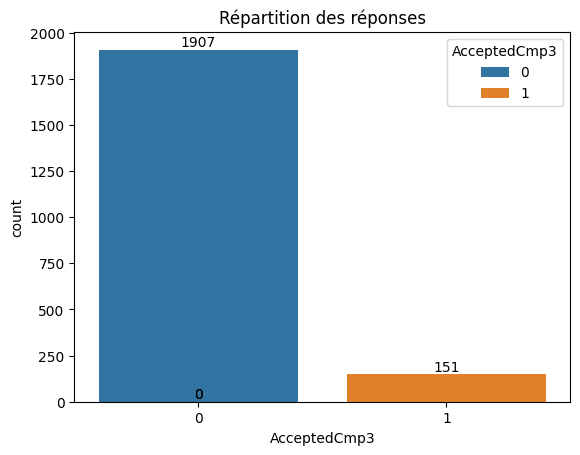

In [14]:
sns.countplot(x='AcceptedCmp3', hue ='AcceptedCmp3', data=df)
plt.title("Répartition des réponses")

for p in plt.gca().patches:
    plt.gca().annotate(
        f'{int(p.get_height())}',           
        (p.get_x() + p.get_width() / 2,     
         p.get_height()),                   
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.show()

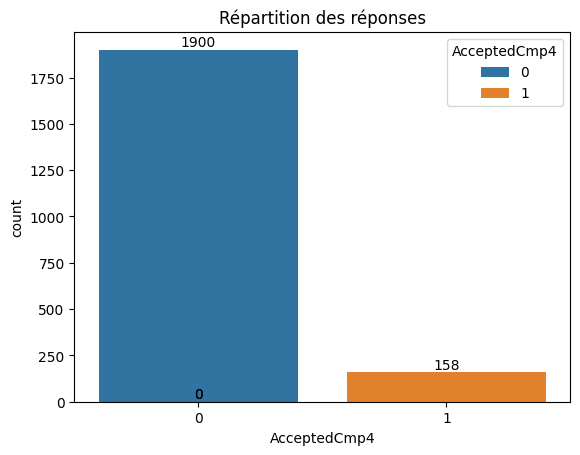

In [15]:
sns.countplot(x='AcceptedCmp4', hue ='AcceptedCmp4', data=df)
plt.title("Répartition des réponses")

for p in plt.gca().patches:
    plt.gca().annotate(
        f'{int(p.get_height())}',           
        (p.get_x() + p.get_width() / 2,     
         p.get_height()),                   
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.show()

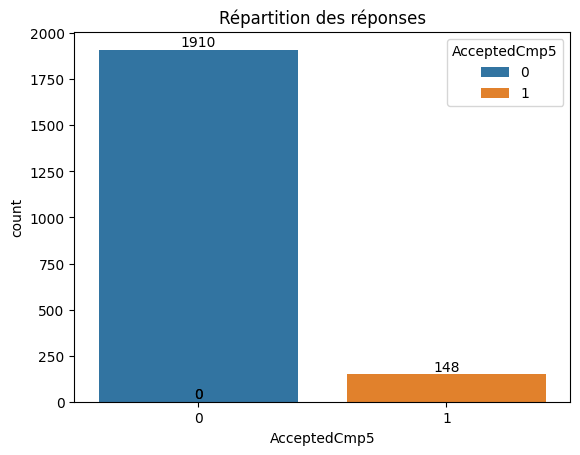

In [16]:
sns.countplot(x='AcceptedCmp5', hue ='AcceptedCmp5', data=df)
plt.title("Répartition des réponses")

for p in plt.gca().patches:
    plt.gca().annotate(
        f'{int(p.get_height())}',           
        (p.get_x() + p.get_width() / 2,     
         p.get_height()),                   
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.show()

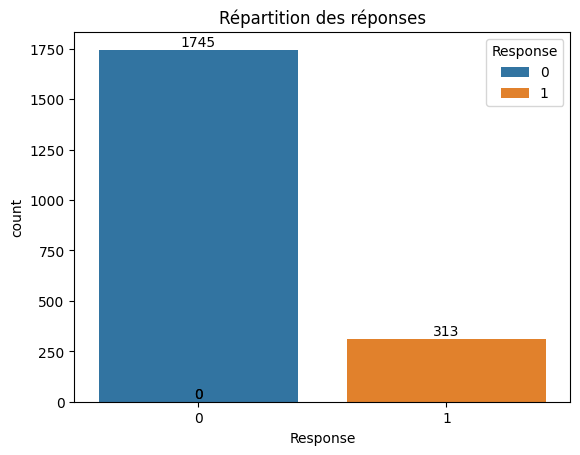

In [17]:
# Répartition de la cible
sns.countplot(x='Response', hue= 'Response', data=df)
plt.title("Répartition des réponses")

for p in plt.gca().patches:
    plt.gca().annotate(
        f'{int(p.get_height())}',           
        (p.get_x() + p.get_width() / 2,     
         p.get_height()),                   
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.show()

On remarque très vite que la deuxième campagne est celle qui a le moins marché parmi les 6, avec seulement  26 réponses positives, tandis que la dernière campgane enregiste le taux le plus élevés de réponses positives avec 313 adhérations.

Maintenant, on va comparer la dernière campagne avec les deux variables catégorielles **education** et **Marital_status**:

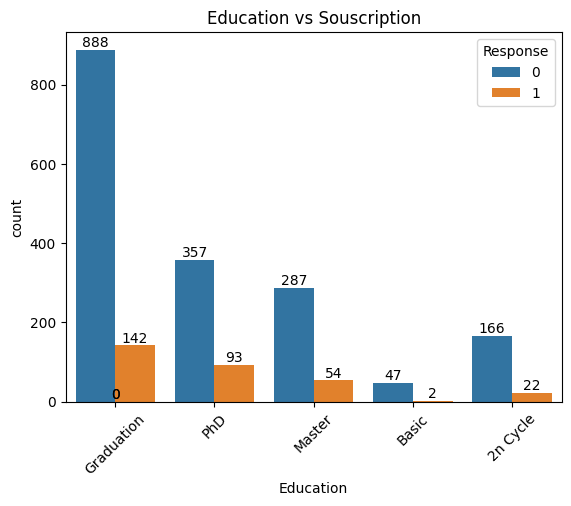

In [18]:
sns.countplot(x='Education', hue='Response', data=df)
plt.xticks(rotation=45)
plt.title("Education vs Souscription")

for p in plt.gca().patches:
    plt.gca().annotate(
        f'{int(p.get_height())}',           
        (p.get_x() + p.get_width() / 2,     
         p.get_height()),                   
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.show()


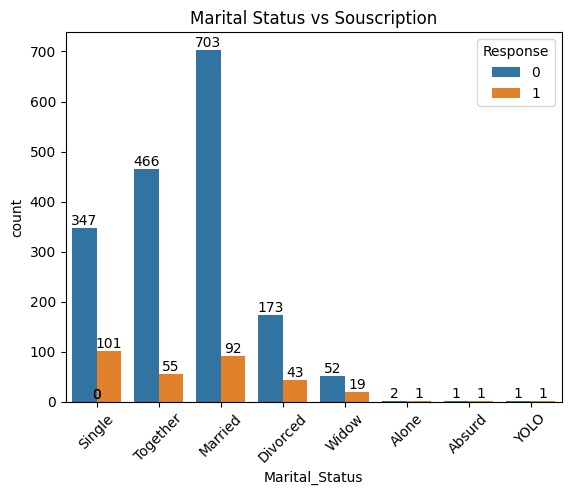

In [19]:
sns.countplot(x='Marital_Status', hue='Response', data=df)
plt.xticks(rotation=45)
plt.title("Marital Status vs Souscription")

for p in plt.gca().patches:
    plt.gca().annotate(
        f'{int(p.get_height())}',           
        (p.get_x() + p.get_width() / 2,     
         p.get_height()),                   
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.show()

En se basant sur ces graphes on remarque que la majorité des clients ont un niveau d'études universitaires (Graduation) et sont marriés. 

Pour rappel, on avait noté un peu plus haut que la plus part des clients n'avaient pas d'enfants/adolescents (voir df.describe()).

La dernière campagne a généré plus de réponses positives de la part des célibataires et des clients dont le niveau d'études est universitaires.

Afin de continuer a bien visualiser les données qu'on possède, on va changer la colonne **Year_Birth** en **Age**, en partant du principe que le dataset est récent, donc d'octobre 2025. Pareil pour **Dt_customer**, on le change en **years_customer** en date time format, il representera donc l'ancienneté (en année) du client.

In [20]:
df['Age'] = (2021 - df['Year_Birth'])
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%Y-%m-%d')
days_in_year = 365.2425
date_now = datetime.strptime('2025 1 Oct', '%Y %d %b')
df['Years_customer'] = (pd.Timestamp('now').year) - (pd.to_datetime(df['Dt_Customer']).dt.year)

Text(0.5, 1.0, 'Age')

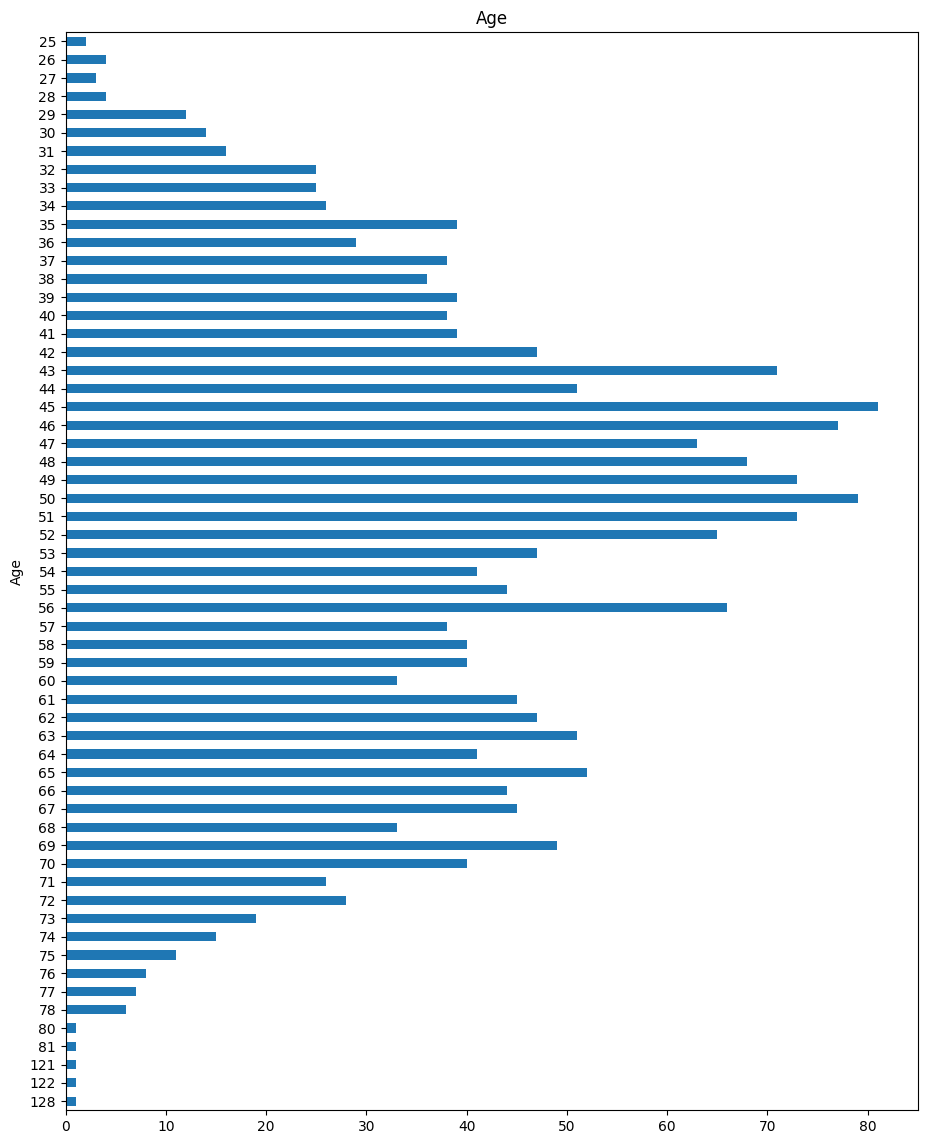

In [21]:
plt.figure(figsize=(11,14))
df['Age'].value_counts().sort_index(ascending=False).plot(kind='barh')
plt.title('Age')

La tranche d'âge des clients varie allant de 43 à 56 ans.

On remarque aussi des clients centenaires, 1 client de 128 ans, 1 de 122 et 1 de 121, on considère que les comptes de ces clients sont utilisés par d'autres personnes.
Ces comptes sont toujours actifs donc on ne les supprime pas.

Text(0.5, 1.0, 'Income')

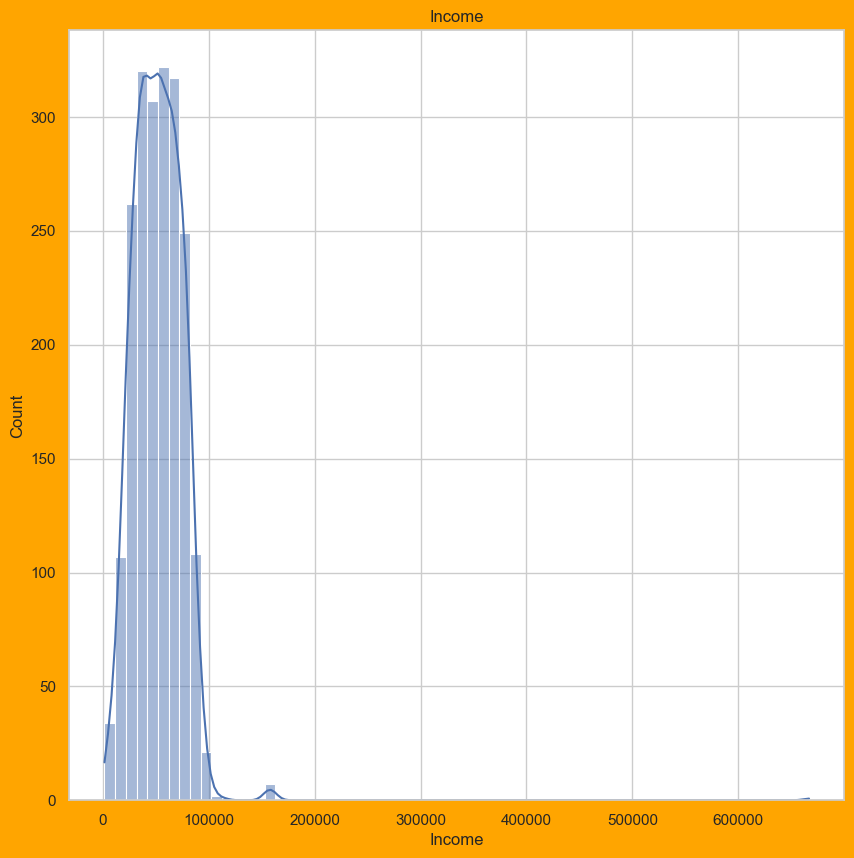

In [22]:
plt.figure(figsize=(10,10), facecolor='orange')
sns.set(style='whitegrid')
ax = sns.histplot(data=df, x='Income', binwidth=10000, kde=True)
ax.set_title('Income')

Les clients réguliers ont un salaire annuel de 30k a 80k.

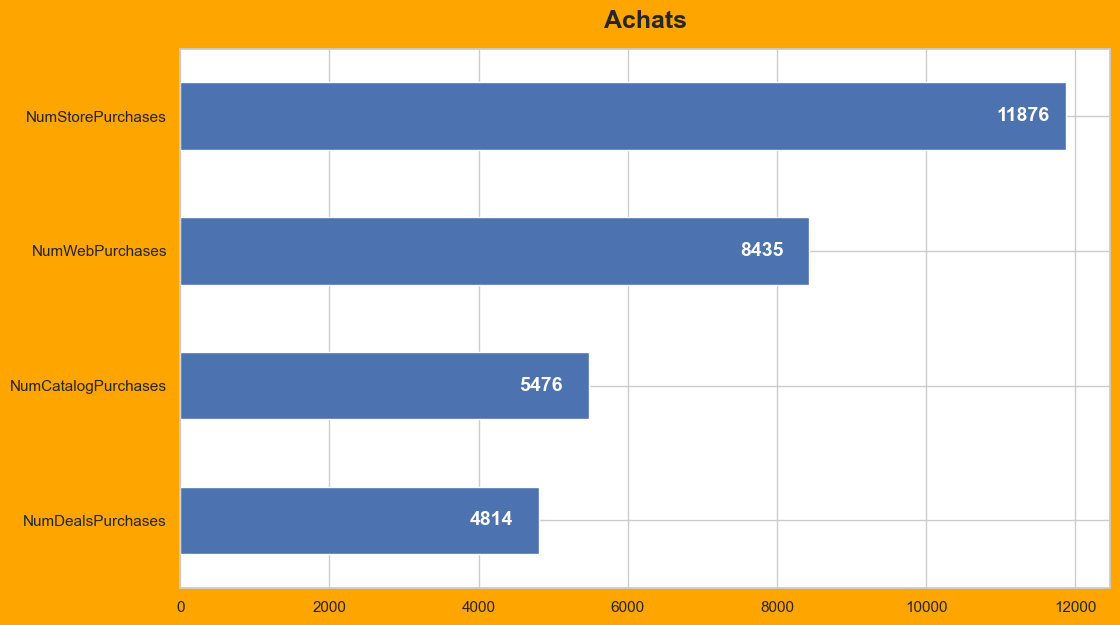

In [23]:
plt.figure(figsize=(12,7), facecolor='orange')
ax = df[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum().sort_values(ascending=True).plot(kind='barh')
plt.title('Achats', pad=15, fontsize=18, fontweight='semibold')
rects = ax.patches
for rect in rects:
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2
        plt.annotate('{}'.format(x_value), (x_value, y_value), xytext=(-50, 0),
                     textcoords='offset points', va='center', ha='left', color = 'white', fontsize=14, fontweight='semibold')

Les achats en magasin représentent la majorité des achats avec plus de 11k achats, suivi des achats sur le site web (8k achats)

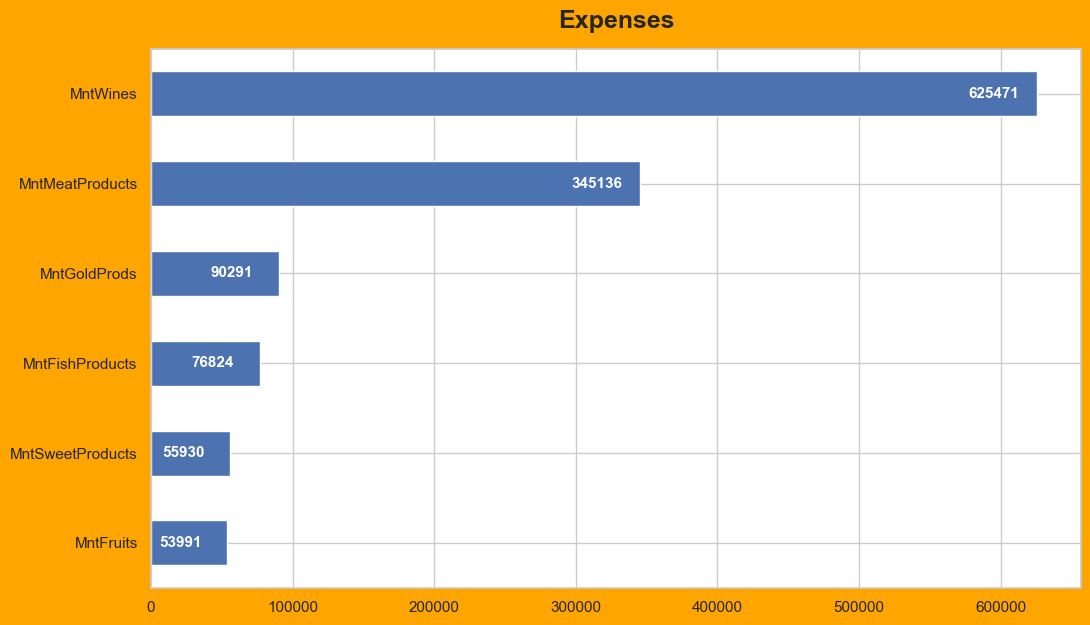

In [24]:
plt.figure(figsize=(12,7), facecolor='orange')
ax = df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum().sort_values(ascending=True).plot(kind='barh')
plt.title('Expenses', pad=15, fontsize=18, fontweight='semibold')
rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    plt.annotate('{}'.format(x_value), (x_value, y_value), xytext=(-49, 0),
    textcoords='offset points', va='center', ha='left', color = 'white', fontsize=11, fontweight='semibold')

A partir du graphe, les produits les plus vendus sont les vins (+600k ventes).

In [25]:
df['Total_Expenses'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['Total_Acc_Cmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response']


# Éviter la division par zéro
df['Panier_per_Campaign'] = df['Total_Expenses'] / df['Total_Acc_Cmp'].replace(0,1)

# Moyenne générale
panier_moyen_campagne = df['Panier_per_Campaign'].mean()
print(f"Le panier moyen par campagne acceptée (sur la durée du dataset) est d'environ {panier_moyen_campagne:.2f} €")


Le panier moyen par campagne acceptée (sur la durée du dataset) est d'environ 523.82 €


Top 10 des clients qui dépensent le plus :

In [26]:
df.sort_values('Total_Expenses', ascending=False).head(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Years_customer,Total_Expenses,Total_Acc_Cmp,Panier_per_Campaign
1179,5735,1991,Master,Single,90638.0,0,0,2014-02-13,29,1156,...,1,0,0,0,0,30,11,2525,1,2525.00
1572,5350,1991,Master,Single,90638.0,0,0,2014-02-13,29,1156,...,1,0,0,0,1,30,11,2525,2,1262.50
1492,1763,1988,Graduation,Together,87679.0,0,0,2013-07-27,62,1259,...,1,1,0,0,1,33,12,2524,4,631.00
987,4580,1969,Graduation,Married,75759.0,0,0,2013-10-25,46,1394,...,1,1,0,0,1,52,12,2486,4,621.50
1052,4475,1949,PhD,Married,69098.0,0,0,2013-02-16,82,1315,...,0,0,0,0,0,72,12,2440,0,2440.00
1601,5453,1956,Master,Married,90226.0,0,0,2012-09-26,26,1083,...,0,1,0,0,0,65,13,2352,1,2352.00
1458,10133,1970,Graduation,Single,93790.0,0,0,2014-02-12,16,1302,...,1,1,0,0,1,51,11,2349,4,587.25
1288,9010,1972,Master,Married,83151.0,0,0,2013-02-10,80,968,...,1,1,0,0,1,49,12,2346,4,586.50
943,5386,1953,Graduation,Together,94384.0,0,0,2013-03-04,62,1111,...,1,1,0,0,1,68,12,2302,4,575.50
1444,1553,1946,Graduation,Together,82657.0,0,0,2013-09-27,71,966,...,0,1,0,0,0,75,12,2283,2,1141.50


- Corrélation : 

<Axes: >

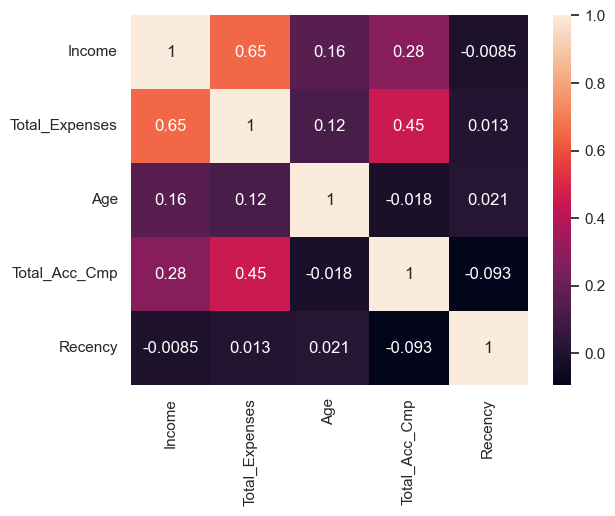

In [27]:


sns.heatmap(df[['Income', 'Total_Expenses','Age', 'Total_Acc_Cmp', 'Recency']].corr(), annot=True)

On remarque qu'il y a une forte corrélation entre les dépenses total (total_expenses) et le salaire (income) de chaque client, et entre les dépenses total et la somme des campagnes (Total_acc_cmp).

- Observation générale des résultats précédents : 

Les clients qui dépensent le plus et qui acceptent le plus de campagnes sont marriés, d'un niveau universitaire, sans enfants et sans ados.


- Mise à l'échelle (data scaling) : 

In [28]:
#faire une copie du dataframe
df_copy=df.copy()

In [29]:
lenc = LabelEncoder()
lenc.fit(df_copy['Marital_Status'])
df_copy['Marital_Status'] = lenc.transform(df_copy['Marital_Status'])

edu = ['Basic', 'Graduation', 'Master', '2n Cycle', 'PhD']
ore = OrdinalEncoder(categories=([edu]))
ore.fit(df_copy[['Education']])
df_copy['Education'] = ore.transform(df_copy[['Education']])

In [30]:
#df_copy = df_copy.drop(['ID', 'Year_Birth', 'Dt_Customer', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','Response', 'Complain'], axis=1)
df_copy = df_copy.drop(['ID', 'Year_Birth', 'Dt_Customer', 'Complain'], axis=1)
data_proc = df_copy.copy()

In [31]:
scaler = StandardScaler()

std_scaler = np.array(data_proc[['Income','Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth','Age', 'Years_customer', 'Total_Expenses', 'Total_Acc_Cmp']]).reshape(-1,19)
scaler.fit(std_scaler)
data_proc[['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth','Age', 'Years_customer', 'Total_Expenses', 'Total_Acc_Cmp']] = scaler.transform(std_scaler)

- Clustering avec K-Means : 

In [32]:
wcss = []
for i in range(1,5):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(data_proc)
    wcss.append(kmeans.inertia_)

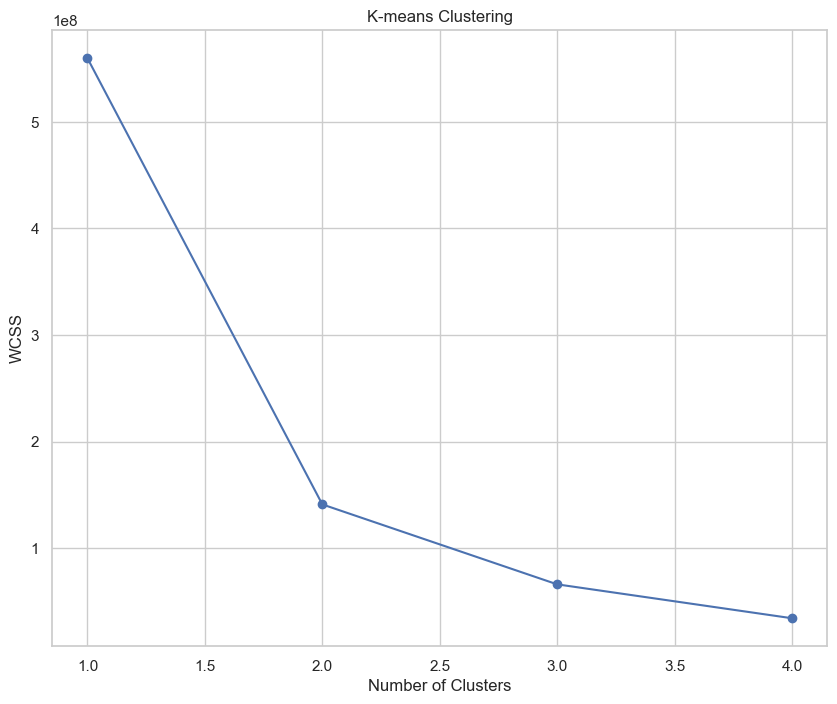

In [33]:
plt.figure(figsize = (10,8))
plt.plot(range(1,5), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

In [34]:
data_proc['Cluster'] = kmeans.labels_
data_proc.groupby('Cluster').mean()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Age,Years_customer,Total_Expenses,Total_Acc_Cmp,Panier_per_Campaign
Cluster,,,,,,,,,,,,,,,,,,,,,
0,2.058212,3.729730,0.275629,-0.345542,0.239954,-0.056927,0.360504,0.088050,0.028665,0.069303,...,0.168399,0.160083,0.155925,0.031185,0.234927,0.094933,0.118870,0.258026,0.453608,521.691407
1,1.992556,3.732010,0.656660,-0.690582,0.021707,0.025710,0.750808,0.647455,0.605183,0.727027,...,0.086849,0.081886,0.069479,0.002481,0.131514,0.241533,0.067798,0.847225,-0.037066,1021.909429
2,1.994924,3.786802,0.952275,-0.725199,-0.439634,0.117392,1.302964,1.104327,1.766942,1.140666,...,0.050761,0.126904,0.086294,0.000000,0.147208,0.122578,0.342298,1.714353,-0.012072,1639.467005
3,1.934493,3.698055,-0.598577,0.601202,-0.038442,-0.006249,-0.749910,-0.533090,-0.620025,-0.564010,...,0.032753,0.013306,0.015353,0.010235,0.120778,-0.171083,-0.155509,-0.822180,-0.205598,94.465660


**Interprétation des résultats :** 

*Les valeurs positives : au dessus de la moyenne globale*
*Les valeurs négatives : en dessous de la moyenne*
*(plus la valeur est éloignée de 0, plus la différence ets marquée*

On a choisis de diviser en 4 ségments les différentes catégories de clients.

- **Cluster 0** : Clients modérément actifs       
*Clients d'un bon niveau de revenu, actifs à la fois en ligne et en magasin, mais sans excès. Potentiel à fidéliser par des offres personalisées*

**Income** : légèrement au dessus de la moyenne (0.27)  
**Dépenses** : légèrement supérieures à la moyenne   
**Recency** : proche de 0 donc activité régulière   
**Achats web** : 0.67 donc élevés    
**Achats magasin** : modérement positifs 0.41     
**Panier moyen par campagne** : 522 euros    


- **Cluster 1** : Clients fidèles et multi-canaux         
  *Clients à revenus confortables, achetant souvent via plusieurs canaux. Très rentables et fidèles.*

**Income**: haut 0.65    
**Dépenses**: élevées mais pas extrêmes     
**Recency**: faible mais ceux sont des clients actifs    
**Achats web & magasin**: très positifs (0.97 / 0.58)      
**Panier moyen par campagne**:  environ 1022 euros


- **Cluster 2** : Clients premium     
  *Clients premium sans enfants, à très haut revenu et forte capacité d’achat. Segment élite de la base*

**Income** : très élevé 0.95    
**Achats catalogues et magasins** : 1.30 & 0.75, particulièrement hauts     
**Dépenses** : toutes >1    
**Recency** : actifs récemment    
**Panier moyen** : 1639 euros     



- **Cluster 3** : Clients à faible revenu (peu engagés)     
  *Familles (avec enfants) à faibles revenus, peu dépensières, probablement sensibles aux promotions. Segment à faible rentabilité mais à fort potentiel de volume.*

**Income** : faible -0.59   
**Dépenses** : très basses dans toutes les catégories (web,magasins,catalogues)    
**Recency** : inactifs récemment    
**Panier moyen** : 94 euros



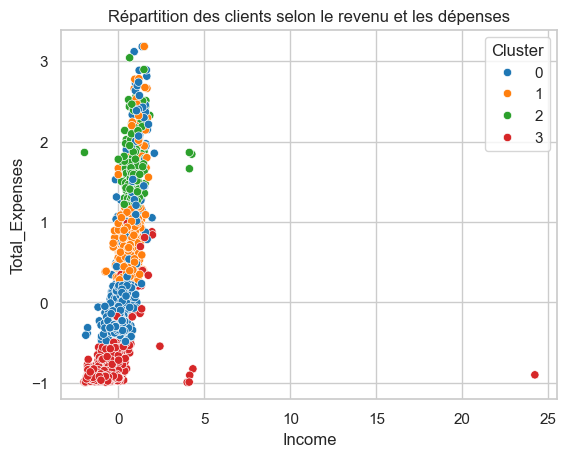

In [35]:
sns.scatterplot(data=data_proc, x='Income', y='Total_Expenses', hue='Cluster', palette='tab10')
plt.title('Répartition des clients selon le revenu et les dépenses')
plt.show()


In [36]:
cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

success_rates = df[cmp_cols].mean() * 100
success_rates.sort_values(ascending=False)

cmp_effect = data_proc.groupby('Cluster')[cmp_cols].mean() * 100
cmp_effect


,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
Cluster,,,,,,
0,15.592516,3.118503,10.602911,16.839917,16.008316,23.492723
1,6.947891,0.248139,4.714640,8.684864,8.188586,13.151365
2,8.629442,0.000000,3.045685,5.076142,12.690355,14.720812
3,1.535312,1.023541,7.676561,3.275333,1.330604,12.077789


- Interprétation des résultats : 


L’analyse des campagnes montre que le cluster 0 est le plus réactif, avec un taux de succès moyen supérieur aux autres pour l’ensemble des campagnes, et particulièrement pour la dernière campagne (23,5 %), la plus performante globalement.
À l’inverse, le cluster 3 représente des clients beaucoup moins sensibles aux actions marketing.     
Cela suggère que les futures campagnes devraient cibler davantage le segment 0  et 2 (car il est constitué de clients à haut revenu et sans enfants, c'est donc la cible la plus rentable), avec des offres premium, tandis que des actions de réactivation seraient nécessaires pour le cluster 3.   



- Modélisation :

On va utiliser RandomForest.
    

In [37]:
X = df_copy.drop('Response', axis=1)  # toutes les colonnes sauf la cible
y = df_copy['Response']               # la cible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



In [38]:
#Creation et entrainement du modèle Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [39]:
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.959546925566343
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       524
           1       0.92      0.81      0.86        94

    accuracy                           0.96       618
   macro avg       0.94      0.90      0.92       618
weighted avg       0.96      0.96      0.96       618

[[517   7]
 [ 18  76]]


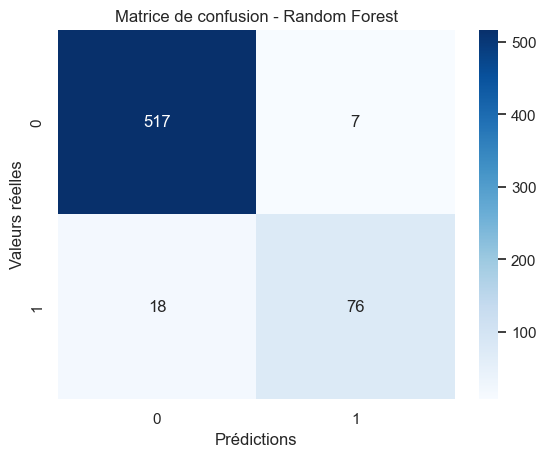

In [40]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.title("Matrice de confusion - Random Forest")
plt.show()

In [44]:
feature_importances = pd.DataFrame({
    'Variable': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importances.head(10))

               Variable  Importance
25        Total_Acc_Cmp    0.358428
5               Recency    0.065216
26  Panier_per_Campaign    0.061523
24       Total_Expenses    0.043042
8       MntMeatProducts    0.035348
6              MntWines    0.034979
19         AcceptedCmp5    0.032486
23       Years_customer    0.032179
2                Income    0.030476
17         AcceptedCmp3    0.028742


Le modèle Random Forest atteint une précision d’environ 95 %.
Les variables les plus déterminantes pour prédire la réponse des clients sont le revenu, le montant total dépensé et la récence des achats.
Ces résultats confirment que les clients à forte capacité d’achat et récemment engagés avec la marque sont plus susceptibles de répondre positivement aux campagnes marketing.

In [45]:
print("Colonnes utilisées lors de l'entraînement:")
print(X_train.columns.tolist())
print(f"\nNombre de colonnes: {len(X_train.columns)}")

Colonnes utilisées lors de l'entraînement:
['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Age', 'Years_customer', 'Total_Expenses', 'Total_Acc_Cmp', 'Panier_per_Campaign']

Nombre de colonnes: 27


In [46]:
# Créer des profils de clients fictifs pour tester le modèle
nouveau_client_1 = pd.DataFrame({
    'Education': [2],  # Graduation
    'Marital_Status': [3],  # Married
    'Income': [70000],
    'Kidhome': [0],
    'Teenhome': [0],
    'Recency': [15],
    'MntWines': [500],
    'MntFruits': [50],
    'MntMeatProducts': [300],
    'MntFishProducts': [80],
    'MntSweetProducts': [40],
    'MntGoldProds': [60],
    'NumDealsPurchases': [2],
    'NumWebPurchases': [6],
    'NumCatalogPurchases': [4],
    'NumStorePurchases': [8],
    'NumWebVisitsMonth': [3],
    'AcceptedCmp3': [0],
    'AcceptedCmp4': [1],
    'AcceptedCmp5': [0],
    'AcceptedCmp1': [0],
    'AcceptedCmp2': [0],
    'Age': [50],
    'Years_customer': [2],
    'Total_Expenses': [1030],
    'Total_Acc_Cmp': [1],
    'Panier_per_Campaign': [1030]
})

# Prédiction
prediction = rf.predict(nouveau_client_1)
proba = rf.predict_proba(nouveau_client_1)

print(f"Prédiction pour le client 1: {'Acceptera' if prediction[0] == 1 else 'Refusera'}")
print(f"Probabilité d'acceptation: {proba[0][1]:.2%}")

Prédiction pour le client 1: Refusera
Probabilité d'acceptation: 24.00%


In [48]:
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print(f"Scores de validation croisée: {cv_scores}")
print(f"Moyenne: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Scores de validation croisée: [0.9684466  0.96601942 0.95873786 0.97323601 0.95863747]
Moyenne: 0.9650 (+/- 0.0113)


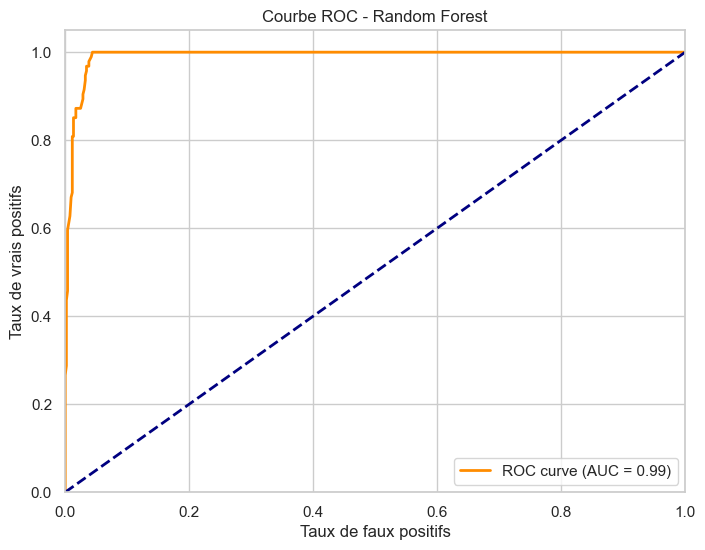

In [51]:
# Obtenir les probabilités prédites
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Visualisation
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Random Forest') 
plt.legend(loc="lower right")
plt.show()